In [1]:
!pip install keras-tuner

In [2]:
import os,keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping,TensorBoard
from tensorflow.keras.models import Sequential
from keras.models import Model,load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,Conv2D, MaxPooling2D
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D

from keras import regularizers
from keras.datasets import cifar10
from keras.optimizers import Adam
from keras.initializers import glorot_uniform

from kerastuner.tuners import RandomSearch
from kerastuner.tuners import Hyperband
from kerastuner.tuners import BayesianOptimization
from kerastuner.engine.hyperparameters import HyperParameters
import pickle

In [3]:
%load_ext autotime
RANDOM_STATE = 42

In [4]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

time: 1.65 s


In [5]:
seed = 7
np.random.seed(seed)

time: 79.8 ms


In [6]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

time: 61.5 ms


In [7]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

time: 5.99 s


In [8]:
tf.test.is_built_with_cuda()

True

time: 2.56 ms


In [9]:
def view_random_image(target_dir, target_class):
    target_folder = target_dir + target_class
    random_image = random.sample(os.listdir(target_folder), 1)
    img = mpimg.imread(target_folder+'/'+random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis('off');
    #print(f"Image shape {img.shape}")
    return img

time: 70.1 ms


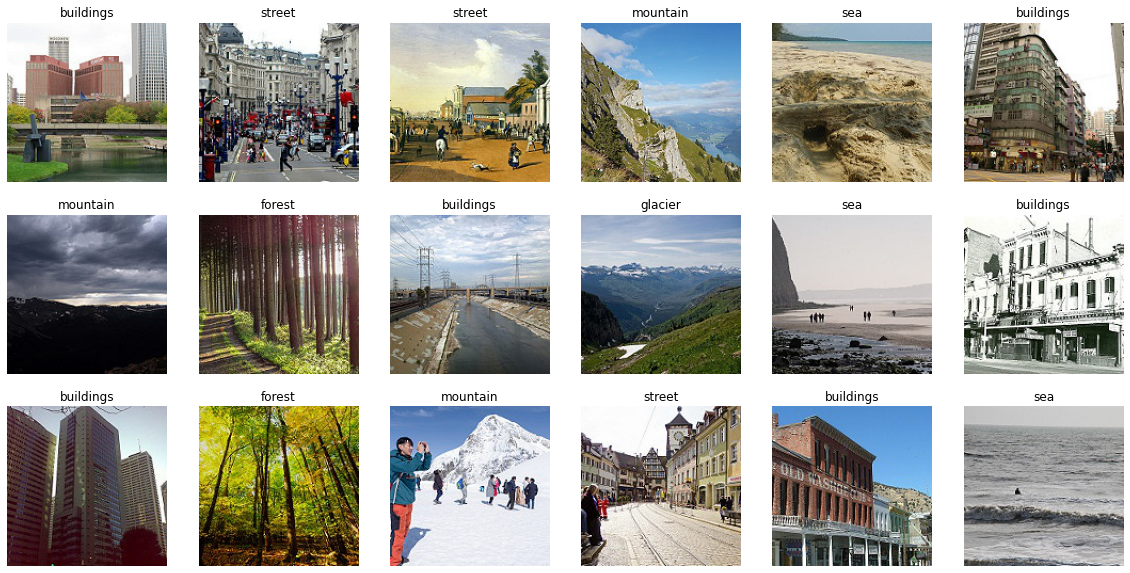

time: 1.49 s


In [10]:
import random
import matplotlib.image as mpimg
from pathlib import Path
import os.path
class_names=['buildings', 'forest', 'glacier', 'mountain' ,'sea' ,'street']
plt.figure(figsize=(20, 10))
for i in range(18):
    plt.subplot(3, 6, i+1)
    class_name = random.choice(class_names)
    img = view_random_image(target_dir='/home/anjir29/Desktop/America/data/archive/seg_train/seg_train/',target_class=class_name)

In [11]:
train_dir = "/home/anjir29/Desktop/America/data/archive/seg_train/seg_train/"
test_dir = "/home/anjir29/Desktop/America/data/archive/seg_test/seg_test/"
val_dir ="/home/anjir29/Desktop/America/data/archive/seg_val/seg_test/"

time: 473 µs


In [12]:
from keras.preprocessing.image import ImageDataGenerator

train_data = ImageDataGenerator(rescale = 1./255)

training_data = train_data.flow_from_directory(train_dir,
                                              batch_size = 32,
                                              target_size = (32,32), 
                                              class_mode = 'categorical')

val_data = ImageDataGenerator(rescale = 1./255)

validation_data = val_data.flow_from_directory(val_dir,
                                            batch_size = 32,
                                            target_size = (32,32), 
                                            class_mode = 'categorical')


test_data = ImageDataGenerator(rescale = 1./255)

testing_data = test_data.flow_from_directory(test_dir,
                                            batch_size = 32,
                                            target_size = (32,32), 
                                            class_mode = 'categorical')

Found 14034 images belonging to 6 classes.
Found 2400 images belonging to 6 classes.
Found 600 images belonging to 6 classes.
time: 750 ms


In [13]:
LOG_DIR = f"{int(time.time())}"

time: 626 µs


In [14]:
def identity_block(X, f, filters, stage, block):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters

    X_shortcut = X
   
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X = Add()([X, X_shortcut])# SKIP Connection
    X = Activation('relu')(X)

    return X

time: 69.1 ms


In [15]:
def convolutional_block(X, f, filters, stage, block, s=2):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

time: 78.2 ms


In [16]:
def build_model(hp):
    input_shape=(32, 32, 3)
    X_input = Input(input_shape)

    X = ZeroPadding2D((1, 1))(X_input)

    X = Conv2D(hp.Choice('s1_filter_size_1', values=[16,32,64,128,256,512],default=16), (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = convolutional_block(X, f=3, filters=[hp.Choice('s2_filter_size_1', values=[16,32,64,128,256,512],default=16), hp.Choice('s2_filter_size_2', values=[16,32,64,128,256,512],default=16), hp.Choice('s2_filter_size_3', values=[16,32,64,128,256,512],default=128)], stage=2, block='a', s=1)
    X = identity_block(X, 3, [hp.Choice('s2_filter_size_1', values=[16,32,64,128,256,512],default=16), hp.Choice('s2_filter_size_2', values=[16,32,64,128,256,512],default=16), hp.Choice('s2_filter_size_3', values=[16,32,64,128,256,512],default=128)], stage=2, block='b')
    X = identity_block(X, 3, [hp.Choice('s2_filter_size_1', values=[16,32,64,128,256,512],default=16), hp.Choice('s2_filter_size_2', values=[16,32,64,128,256,512],default=16), hp.Choice('s2_filter_size_3', values=[16,32,64,128,256,512],default=128)], stage=2, block='c')

    X = convolutional_block(X, f=3, filters=[hp.Choice('s3_filter_size_1', values=[16,32,64,128,256,512],default=16), hp.Choice('s3_filter_size_2', values=[16,32,64,128,256,512],default=16), hp.Choice('s3_filter_size_3', values=[16,32,64,128,256,512],default=128)], stage=3, block='a', s=2)
    X = identity_block(X, 3, [hp.Choice('s3_filter_size_1', values=[16,32,64,128,256,512],default=16), hp.Choice('s3_filter_size_2', values=[16,32,64,128,256,512],default=16), hp.Choice('s3_filter_size_3', values=[16,32,64,128,256,512],default=128)], stage=3, block='b')
    X = identity_block(X, 3, [hp.Choice('s3_filter_size_1', values=[16,32,64,128,256,512],default=16), hp.Choice('s3_filter_size_2', values=[16,32,64,128,256,512],default=16), hp.Choice('s3_filter_size_3', values=[16,32,64,128,256,512],default=128)], stage=3, block='c')
    X = identity_block(X, 3, [hp.Choice('s3_filter_size_1', values=[16,32,64,128,256,512],default=16), hp.Choice('s3_filter_size_2', values=[16,32,64,128,256,512],default=16), hp.Choice('s3_filter_size_3', values=[16,32,64,128,256,512],default=128)], stage=3, block='d')

    X = convolutional_block(X, f=3, filters=[hp.Choice('s4_filter_size_1', values=[16,32,64,128,256,512],default=16), hp.Choice('s4_filter_size_2', values=[16,32,64,128,256,512],default=16), hp.Choice('s4_filter_size_3', values=[16,32,64,128,256,512],default=128)], stage=4, block='a', s=2)
    X = identity_block(X, 3, [hp.Choice('s4_filter_size_1', values=[16,32,64,128,256,512],default=16), hp.Choice('s4_filter_size_2', values=[16,32,64,128,256,512],default=16), hp.Choice('s4_filter_size_3', values=[16,32,64,128,256,512],default=128)], stage=4, block='b')
    X = identity_block(X, 3, [hp.Choice('s4_filter_size_1', values=[16,32,64,128,256,512],default=16), hp.Choice('s4_filter_size_2', values=[16,32,64,128,256,512],default=16), hp.Choice('s4_filter_size_3', values=[16,32,64,128,256,512],default=128)], stage=4, block='c')
    X = identity_block(X, 3, [hp.Choice('s4_filter_size_1', values=[16,32,64,128,256,512],default=16), hp.Choice('s4_filter_size_2', values=[16,32,64,128,256,512],default=16), hp.Choice('s4_filter_size_3', values=[16,32,64,128,256,512],default=128)], stage=4, block='d')
    X = identity_block(X, 3, [hp.Choice('s4_filter_size_1', values=[16,32,64,128,256,512],default=16), hp.Choice('s4_filter_size_2', values=[16,32,64,128,256,512],default=16), hp.Choice('s4_filter_size_3', values=[16,32,64,128,256,512],default=128)], stage=4, block='e')
    X = identity_block(X, 3, [hp.Choice('s4_filter_size_1', values=[16,32,64,128,256,512],default=16), hp.Choice('s4_filter_size_2', values=[16,32,64,128,256,512],default=16), hp.Choice('s4_filter_size_3', values=[16,32,64,128,256,512],default=128)], stage=4, block='f')

    X = X = convolutional_block(X, f=3, filters=[hp.Choice('s5_filter_size_1', values=[16,32,64,128,256,512],default=16), hp.Choice('s5_filter_size_2', values=[16,32,64,128,256,512],default=16), hp.Choice('s5_filter_size_3', values=[16,32,64,128,256,512],default=128)], stage=5, block='a', s=2)
    X = identity_block(X, 3, [hp.Choice('s5_filter_size_1', values=[16,32,64,128,256,512],default=16), hp.Choice('s5_filter_size_2', values=[16,32,64,128,256,512],default=16), hp.Choice('s5_filter_size_3', values=[16,32,64,128,256,512],default=128)], stage=5, block='b')
    X = identity_block(X, 3, [hp.Choice('s5_filter_size_1', values=[16,32,64,128,256,512],default=16), hp.Choice('s5_filter_size_2', values=[16,32,64,128,256,512],default=16), hp.Choice('s5_filter_size_3', values=[16,32,64,128,256,512],default=128)], stage=5, block='c')

    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)

    X= Dropout(hp.Choice('dp_size_1', values=[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8],default=0.0))(X)
    X = Flatten()(X)
    X=Dense(hp.Choice('dense_size_1', values=[64,128,256,512],default=64), activation='relu',kernel_regularizer=regularizers.l2(hp.Choice('wd_size_1', values=[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8],default=0.0)), name='fc1',kernel_initializer=glorot_uniform(seed=0))(X)
    X=Dense(hp.Choice('dense_size_2', values=[64,128,256,512],default=64), activation='relu',kernel_regularizer=regularizers.l2(hp.Choice('wd_size_2', values=[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8],default=0.0)), name='fc2',kernel_initializer=glorot_uniform(seed=0))(X)
    X= Dropout(hp.Choice('dp_size_2', values=[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8],default=0.0))(X)
    X = Dense(6,activation='softmax', name='fc3',kernel_initializer=glorot_uniform(seed=0))(X)

    model = Model(inputs=X_input, outputs=X, name='ResNet50')

    my_callbacks = [ tf.keras.callbacks.EarlyStopping(patience=3)]
    opt = Adam(learning_rate=hp.Choice('learning_rate', values=[1e-1,1e-2, 1e-3, 1e-4, 1e-5],default=1e-2))

    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                                    optimizer=opt,
                                    metrics=['accuracy'])
    
    return model


time: 73.2 ms


In [17]:
tuner = BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=20,  # how many model variations to test?
    executions_per_trial=1,  # how many trials per variation? (same model could perform differently)
    directory=LOG_DIR,
    project_name='BS_ResNet50_Intel')

tuner.search_space_summary()
my_callbacks = [ tf.keras.callbacks.EarlyStopping(patience=3)]
tuner.search(training_data,
             verbose=1, # just slapping this here bc jupyter notebook. The console out was getting messy.
             epochs=30,
             batch_size=64,
             callbacks=[my_callbacks],  # if you have callbacks like tensorboard, they go here.
             validation_data=validation_data)
tuner.results_summary()
with open(f"tuner_{int(time.time())}.pkl", "wb") as f:
    pickle.dump(tuner, f)

Trial 20 Complete [00h 02m 00s]
val_accuracy: 0.4820833206176758

Best val_accuracy So Far: 0.6895833611488342
Total elapsed time: 01h 09m 38s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in 1624426750/BS_ResNet50_Intel
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
s1_filter_size_1: 512
s2_filter_size_1: 16
s2_filter_size_2: 32
s2_filter_size_3: 512
s3_filter_size_1: 16
s3_filter_size_2: 512
s3_filter_size_3: 512
s4_filter_size_1: 32
s4_filter_size_2: 16
s4_filter_size_3: 512
s5_filter_size_1: 512
s5_filter_size_2: 32
s5_filter_size_3: 512
dp_size_1: 0.8
dense_size_1: 128
wd_size_1: 0.0
dense_size_2: 64
wd_size_2: 0.0
dp_size_2: 0.0
learning_rate: 0.0001
Score: 0.6895833611488342
Trial summary
Hyperparameters:
s1_filter_size_1: 512
s2_filter_size_1: 16
s2_filter_size_2: 16
s2_filter_size_3: 512
s3_filter_size_1: 16
s3_filter_size_2: 512
s3_filter_size_3: 512
s4_filter_size_1: 16
s4_filter_size_2: 16
s4_filter_size

In [18]:
new_model = tuner.get_best_hyperparameters()[0]

time: 620 µs


In [19]:
model = tuner.hypermodel.build(new_model)

time: 1.38 s


In [20]:
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 34, 34, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 14, 14, 512)  75776       zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 14, 14, 512)  2048        conv1[0][0]                      
___________________________________________________________________________________________

In [21]:
hist=model.fit(training_data,
      batch_size=64,
      epochs=100,
      validation_data=validation_data,
      callbacks=[my_callbacks])

Epoch 1/100
439/439 [==============================] - 21s 37ms/step - loss: 3.0018 - accuracy: 0.1825 - val_loss: 1.7867 - val_accuracy: 0.1637
Epoch 2/100
439/439 [==============================] - 15s 35ms/step - loss: 1.8771 - accuracy: 0.2669 - val_loss: 1.5257 - val_accuracy: 0.3438
Epoch 3/100
439/439 [==============================] - 15s 35ms/step - loss: 1.6245 - accuracy: 0.3393 - val_loss: 1.3967 - val_accuracy: 0.4354
Epoch 4/100
439/439 [==============================] - 15s 35ms/step - loss: 1.4502 - accuracy: 0.4263 - val_loss: 1.2533 - val_accuracy: 0.5025
Epoch 5/100
439/439 [==============================] - 16s 36ms/step - loss: 1.3055 - accuracy: 0.4889 - val_loss: 1.1593 - val_accuracy: 0.5546
Epoch 6/100
439/439 [==============================] - 16s 35ms/step - loss: 1.1925 - accuracy: 0.5311 - val_loss: 1.0938 - val_accuracy: 0.5775
Epoch 7/100
439/439 [==============================] - 15s 35ms/step - loss: 1.1157 - accuracy: 0.5709 - val_loss: 1.2436 - val_ac

In [23]:
_,test_acc = model.evaluate(testing_data[0][0],testing_data[0][1])

1/1 [==============================] - 0s 22ms/step - loss: 1.0814 - accuracy: 0.5625
time: 95.3 ms
